<a href="https://www.kaggle.com/code/dataranch/tsla-pricing-eda-model-comparison?scriptVersionId=106682281" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**TSLA Pricing Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

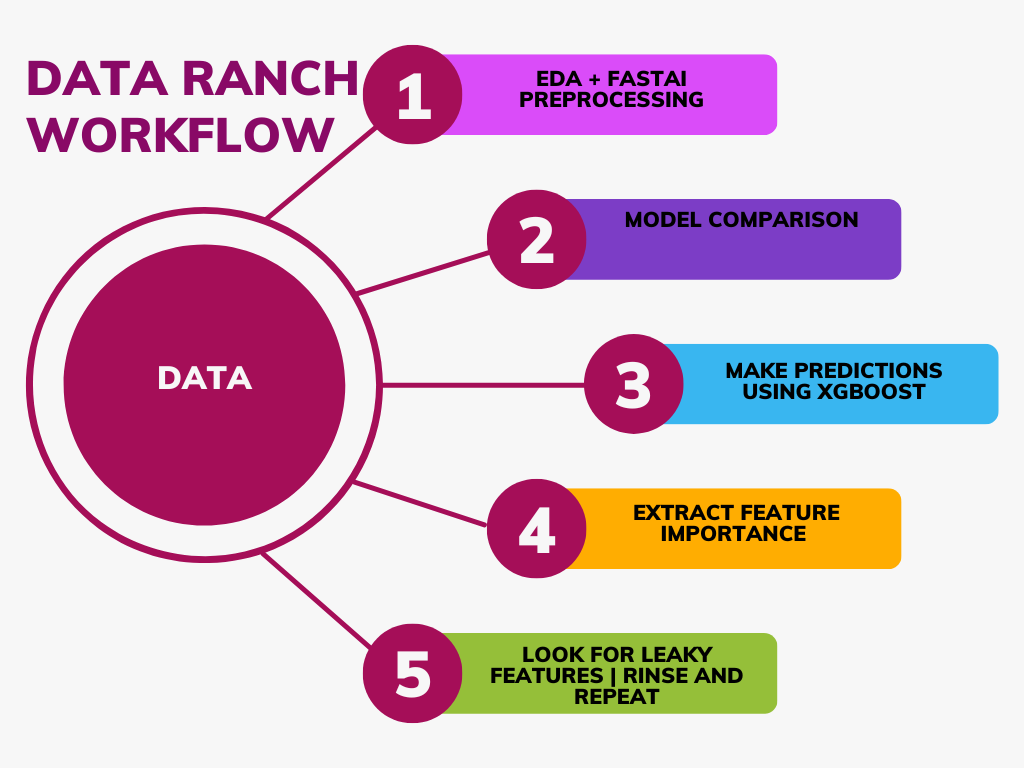

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 241.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.1/248.1 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 21.7 MB/s eta 0:00:00
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86

In [3]:
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 9.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.5
    Uninstalling pandas-1.0.5:
      Successfully uninstalled pandas-1.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.1 which is incompatible.
tfx-bsl 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 473.4 kB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.1 which is incompatible.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.19.1 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,

In [6]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [7]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'tesla-stock-pricing-20172022'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = True
SEP_PERCENT = True
SHUFFLE_DATA = True

In [8]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/tesla-stock-pricing-20172022
CSV!


In [9]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-09-18,25.35,25.97,25.18,25.67,25.67,107820000
1,2017-09-19,25.33,25.49,24.90,25.01,25.01,96778500
2,2017-09-20,24.87,25.22,24.74,24.93,24.93,73786500
3,2017-09-21,24.99,25.12,24.30,24.43,24.43,69273000
4,2017-09-22,24.43,24.66,23.39,23.41,23.41,122391000
...,...,...,...,...,...,...,...
1254,2022-09-12,300.72,305.49,300.40,304.42,304.42,48674600
1255,2022-09-13,292.90,297.40,290.40,292.13,292.13,68229600
1256,2022-09-14,292.24,306.00,291.64,302.61,302.61,72628700
1257,2022-09-15,301.83,309.12,300.72,303.75,303.75,64795500


In [10]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

<AxesSubplot:>

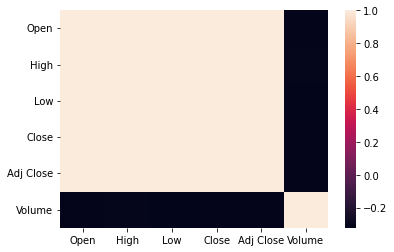

In [11]:
sns.heatmap(df.corr())

In [12]:
df.head().style.background_gradient(cmap = "inferno")

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-09-18,25.35,25.97,25.18,25.67,25.67,107820000
1,2017-09-19,25.33,25.49,24.90,25.01,25.01,96778500
2,2017-09-20,24.87,25.22,24.74,24.93,24.93,73786500
3,2017-09-21,24.99,25.12,24.30,24.43,24.43,69273000
4,2017-09-22,24.43,24.66,23.39,23.41,23.41,122391000


In [13]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
Open,1259.00,121.34,118.69,12.07,20.81,47.39,233.38,411.47
High,1259.00,124.14,121.41,12.45,21.13,49.58,238.44,414.50
Low,1259.00,118.31,115.65,11.80,20.35,45.80,227.15,405.67
Close,1259.00,121.31,118.57,11.93,20.78,48.30,233.14,409.97
Adj Close,1259.00,121.31,118.57,11.93,20.78,48.30,233.14,409.97
Volume,1259.00,132004874.03,90257111.18,29401800.00,75423750.00,101611500.00,152689500.00,914082000.00


In [14]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [15]:
#remove leaky date feature
del(df['Date'])

Target Variable: Volume
CATS=====================
[]
CONTS=====================
['Open', 'High', 'Low', 'Close', 'Adj Close']
5
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Open', 'High', 'Low', 'Close', 'Adj Close']
Categorical variables that made the cut : []
Tabular Object size: 1259


 17%|█▋        | 7/42 [00:00<00:01, 29.59it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.24326394222388126, 'Adjusted R-Squared': 0.22782034920804206, 'RMSE': 85043300.56799941, 'Time taken': 0.08239126205444336}
{'Model': 'BaggingRegressor', 'R-Squared': 0.40455492248062186, 'Adjusted R-Squared': 0.39240298212308355, 'RMSE': 75437753.62812604, 'Time taken': 0.060730695724487305}
{'Model': 'BayesianRidge', 'R-Squared': -0.0023650276084710153, 'Adjusted R-Squared': -0.022821456743337798, 'RMSE': 97877044.25003044, 'Time taken': 0.012305498123168945}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.1908263905553047, 'Adjusted R-Squared': 0.17431264342378028, 'RMSE': 87940463.03409795, 'Time taken': 0.016356706619262695}
{'Model': 'DummyRegressor', 'R-Squared': -0.0023650434092832295, 'Adjusted R-Squared': -0.022821472866615622, 'RMSE': 97877050.0, 'Time taken': 0.009691715240478516}
{'Model': 'ElasticNet', 'R-Squared': 0.09366743784384535, 'Adjusted R-Squared': 0.07517085494269926, 'RMSE': 93070424.0, 'Time taken': 0.01306939125

 26%|██▌       | 11/42 [00:00<00:02, 12.39it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.23281436085857488, 'Adjusted R-Squared': -0.25797383761079073, 'RMSE': 108546727.6362914, 'Time taken': 0.20447134971618652}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': 0.09026640580053269, 'Adjusted R-Squared': 0.0717004140821762, 'RMSE': 93244883.16397008, 'Time taken': 0.03979063034057617}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.4673282537637742, 'Adjusted R-Squared': 0.45645740179976957, 'RMSE': 71350615.48277642, 'Time taken': 0.23720312118530273}


 40%|████      | 17/42 [00:01<00:02,  9.19it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.5077981785808591, 'Adjusted R-Squared': 0.49775324344985616, 'RMSE': 68586635.8128246, 'Time taken': 0.47985100746154785}
{'Model': 'HuberRegressor', 'R-Squared': -0.032665300438998734, 'Adjusted R-Squared': -0.053740102488774255, 'RMSE': 99345382.21221508, 'Time taken': 0.02234029769897461}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.45234679520496224, 'Adjusted R-Squared': 0.441170199188737, 'RMSE': 72347030.0, 'Time taken': 0.013747215270996094}
{'Model': 'KernelRidge', 'R-Squared': -1.781976973894138, 'Adjusted R-Squared': -1.8387520141776919, 'RMSE': 163058960.0, 'Time taken': 0.10219812393188477}
{'Model': 'Lars', 'R-Squared': 0.17454922019010466, 'Adjusted R-Squared': 0.1577032859082701, 'RMSE': 88820555.29084833, 'Time taken': 0.031899452209472656}


 50%|█████     | 21/42 [00:01<00:01, 10.67it/s]

{'Model': 'LarsCV', 'R-Squared': 0.17454922019010466, 'Adjusted R-Squared': 0.1577032859082701, 'RMSE': 88820555.29084833, 'Time taken': 0.07880139350891113}
{'Model': 'Lasso', 'R-Squared': 0.1635997334267908, 'Adjusted R-Squared': 0.1465303402314192, 'RMSE': 89407710.0, 'Time taken': 0.014696836471557617}
{'Model': 'LassoCV', 'R-Squared': 0.16309089598522908, 'Adjusted R-Squared': 0.14601111835227454, 'RMSE': 89434904.0, 'Time taken': 0.14992165565490723}
{'Model': 'LassoLars', 'R-Squared': 0.17454942715665478, 'Adjusted R-Squared': 0.1577034970986273, 'RMSE': 88820544.15579006, 'Time taken': 0.012580633163452148}
{'Model': 'LassoLarsCV', 'R-Squared': 0.17454922019010466, 'Adjusted R-Squared': 0.1577032859082701, 'RMSE': 88820555.29084833, 'Time taken': 0.02501082420349121}
{'Model': 'LassoLarsIC', 'R-Squared': 0.17454922019010466, 'Adjusted R-Squared': 0.1577032859082701, 'RMSE': 88820555.29084833, 'Time taken': 0.012908935546875}
{'Model': 'LinearRegression', 'R-Squared': 0.17008204

 69%|██████▉   | 29/42 [00:03<00:01,  7.15it/s]

{'Model': 'MLPRegressor', 'R-Squared': -1.9298926781463486, 'Adjusted R-Squared': -1.9896864062717845, 'RMSE': 167337682.15017244, 'Time taken': 1.2309684753417969}
{'Model': 'NuSVR', 'R-Squared': -0.053936200402238565, 'Adjusted R-Squared': -0.0754451024512639, 'RMSE': 100363327.98706634, 'Time taken': 0.11681079864501953}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.0997189471858102, 'Adjusted R-Squared': 0.08134586447531655, 'RMSE': 92759190.08099739, 'Time taken': 0.013299942016601562}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.17011400528958465, 'Adjusted R-Squared': 0.1531775564179435, 'RMSE': 89058855.69054446, 'Time taken': 0.01625967025756836}


 76%|███████▌  | 32/42 [00:03<00:01,  9.18it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.9013648724911345, 'Adjusted R-Squared': -1.9605764005011577, 'RMSE': 166521021.83893842, 'Time taken': 0.070953369140625}
{'Model': 'PoissonRegressor', 'R-Squared': 0.10296112022680037, 'Adjusted R-Squared': 0.08465420431306159, 'RMSE': 92592013.06595044, 'Time taken': 0.019383668899536133}
{'Model': 'RANSACRegressor', 'R-Squared': -0.15860250369999385, 'Adjusted R-Squared': -0.18224745275509568, 'RMSE': 105228920.0, 'Time taken': 0.06945085525512695}


 90%|█████████ | 38/42 [00:04<00:00, 10.16it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.4760980611959299, 'Adjusted R-Squared': 0.46540618489380603, 'RMSE': 70760826.3075276, 'Time taken': 0.45093631744384766}
{'Model': 'Ridge', 'R-Squared': 0.15277912762262102, 'Adjusted R-Squared': 0.13548890573736838, 'RMSE': 89984190.0, 'Time taken': 0.010854482650756836}
{'Model': 'RidgeCV', 'R-Squared': 0.17565046772987503, 'Adjusted R-Squared': 0.1588270078876276, 'RMSE': 88761287.03052737, 'Time taken': 0.009946823120117188}
{'Model': 'SGDRegressor', 'R-Squared': 0.09816437110722998, 'Adjusted R-Squared': 0.07975956235431625, 'RMSE': 92839242.31619172, 'Time taken': 0.011049747467041016}
{'Model': 'SVR', 'R-Squared': -0.12449878967056849, 'Adjusted R-Squared': -0.14744774456180454, 'RMSE': 103668637.10835198, 'Time taken': 0.0799565315246582}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.17008204963965923, 'Adjusted R-Squared': 0.1531449486118972, 'RMSE': 89060580.0, 'Time taken': 0.013702630996704102}
{'Model': 'TweedieRe

100%|██████████| 42/42 [00:04<00:00,  9.52it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.4477219192850779, 'Adjusted R-Squared': 0.43645093804599777, 'RMSE': 72651870.0, 'Time taken': 0.1008296012878418}
{'Model': 'LGBMRegressor', 'R-Squared': 0.4759077776118382, 'Adjusted R-Squared': 0.46521201797126344, 'RMSE': 70773675.46904488, 'Time taken': 0.11942386627197266}
Project: tesla-stock-pricing-20172022
tesla-stock-pricing-20172022
Target: Volume
Volume
Target Standard Deviation: 88218008.0
                               Adjusted R-Squared  R-Squared         RMSE  \
Model                                                                       
ExtraTreesRegressor                          0.53       0.54  66298752.59   
HistGradientBoostingRegressor                0.50       0.51  68586635.81   
RandomForestRegressor                        0.47       0.48  70760826.31   
LGBMRegressor                                0.47       0.48  70773675.47   
GradientBoostingRegressor                    0.46       0.47  71350615.48   
KNeighborsReg

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,25350870518464512.000000,28002018538815488.000000,167338048.000000,00:00
1,25069322527309824.000000,28001960556756992.000000,167337872.000000,00:00
2,25036431667757056.000000,28001376441204736.000000,167336112.000000,00:00
3,24919814715736064.000000,27981099900600320.000000,167275520.000000,00:00
4,24906788079927296.000000,27976495695659008.000000,167261760.000000,00:00
5,24815732625768448.000000,27958308656644096.000000,167207376.000000,00:00
6,24829510880854016.000000,27935382121218048.000000,167138816.000000,00:00
7,24758871553736704.000000,27924524443893760.000000,167106336.000000,00:00
8,24834559614910464.000000,27953470375985152.000000,167192912.000000,00:00


Better model found at epoch 0 with _rmse value: 167338048.0.
Better model found at epoch 1 with _rmse value: 167337872.0.
Better model found at epoch 2 with _rmse value: 167336112.0.
Better model found at epoch 3 with _rmse value: 167275520.0.
Better model found at epoch 4 with _rmse value: 167261760.0.
Better model found at epoch 5 with _rmse value: 167207376.0.
Better model found at epoch 6 with _rmse value: 167138816.0.
Better model found at epoch 7 with _rmse value: 167106336.0.
No improvement since epoch 7: early stopping


,Open,High,Low,Close,Adj Close,Volume,Volume_pred
0,0.15,0.13,0.16,0.15,0.15,52073100.00,288782.03
1,-0.88,-0.88,-0.88,-0.88,-0.88,119925000.00,396279.38
2,-0.17,-0.17,-0.16,-0.17,-0.17,141403504.00,280119.19
3,-0.77,-0.77,-0.78,-0.77,-0.77,246817504.00,381766.75
4,-0.69,-0.69,-0.69,-0.69,-0.69,267022496.00,365662.00
5,0.91,0.89,0.94,0.92,0.92,84815400.00,9794.37
6,1.82,1.81,1.83,1.79,1.79,69696600.00,5958.83
7,-0.89,-0.89,-0.89,-0.89,-0.89,76477504.00,396295.22
8,1.41,1.42,1.44,1.40,1.40,82002000.00,6612.36


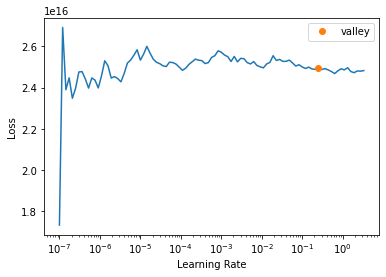

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
        actual    predicted
0 105424496.00 111164512.00
1  62566200.00  87762200.00
2 125257504.00 116273024.00
3  62696700.00  70266200.00
4  84774000.00  95717616.00
XGBoost RMSE:  72651870.0


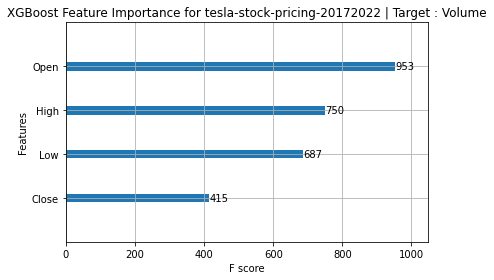

Target Variable: Adj Close
CATS=====================
[]
CONTS=====================
['Open', 'High', 'Low', 'Close', 'Volume']
5
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Open', 'High', 'Low', 'Close', 'Volume']
Categorical variables that made the cut : []
Tabular Object size: 1259


 17%|█▋        | 7/42 [00:00<00:01, 29.81it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9975642081685913, 'Adjusted R-Squared': 0.9975144981312156, 'RMSE': 5.800264431935833, 'Time taken': 0.09186649322509766}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9999483188898773, 'Adjusted R-Squared': 0.9999472641733442, 'RMSE': 0.8448772682515324, 'Time taken': 0.05673789978027344}
{'Model': 'BayesianRidge', 'R-Squared': 0.9999999999999982, 'Adjusted R-Squared': 0.9999999999999982, 'RMSE': 4.996392080448487e-06, 'Time taken': 0.012344598770141602}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9999183193633758, 'Adjusted R-Squared': 0.999916652411608, 'RMSE': 1.0621534534509829, 'Time taken': 0.014512777328491211}
{'Model': 'DummyRegressor', 'R-Squared': -6.192997384868448e-05, 'Adjusted R-Squared': -0.020471357116172095, 'RMSE': 117.52795, 'Time taken': 0.009254932403564453}
{'Model': 'ElasticNet', 'R-Squared': 0.9856376932965174, 'Adjusted R-Squared': 0.9853445849964463, 'RMSE': 14.084447, 'Time taken': 0.01005101203918457}
{'Mo

 26%|██▌       | 11/42 [00:00<00:02, 13.81it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9999692385330358, 'Adjusted R-Squared': 0.9999686107479957, 'RMSE': 0.6518253247670663, 'Time taken': 0.2626678943634033}
{'Model': 'GammaRegressor', 'R-Squared': 0.8679344912228686, 'Adjusted R-Squared': 0.8652392767580291, 'RMSE': 42.7092960111416, 'Time taken': 0.012845039367675781}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9999958803456596, 'Adjusted R-Squared': 0.9999957962710811, 'RMSE': 0.23853828775695052, 'Time taken': 0.17226576805114746}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': 0.9589389320142849, 'Adjusted R-Squared': 0.9581009510349846, 'RMSE': 23.814574649536112, 'Time taken': 0.026702404022216797}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999415528425747, 'Adjusted R-Squared': 0.9999403600434436, 'RMSE': 0.8984820508566401, 'Time taken': 0.2305738925933838}


 40%|████      | 17/42 [00:01<00:02, 10.24it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.999669496125103, 'Adjusted R-Squared': 0.9996627511480644, 'RMSE': 2.136564392652928, 'Time taken': 0.4224557876586914}
{'Model': 'HuberRegressor', 'R-Squared': 0.9999999999999957, 'Adjusted R-Squared': 0.9999999999999956, 'RMSE': 7.731026070678878e-06, 'Time taken': 0.06582140922546387}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9989688257633684, 'Adjusted R-Squared': 0.9989477813911922, 'RMSE': 3.773929, 'Time taken': 0.01328897476196289}
{'Model': 'KernelRidge', 'R-Squared': -0.07020667874311703, 'Adjusted R-Squared': -0.09204763137052763, 'RMSE': 121.579834, 'Time taken': 0.039960384368896484}
{'Model': 'Lars', 'R-Squared': 0.999999999906909, 'Adjusted R-Squared': 0.9999999999050092, 'RMSE': 0.0011339172936689094, 'Time taken': 0.017432212829589844}


 55%|█████▍    | 23/42 [00:01<00:01, 14.96it/s]

{'Model': 'LarsCV', 'R-Squared': 0.999999999999917, 'Adjusted R-Squared': 0.9999999999999153, 'RMSE': 3.387418545333279e-05, 'Time taken': 0.07076621055603027}
{'Model': 'Lasso', 'R-Squared': 0.9997471190925792, 'Adjusted R-Squared': 0.9997419582577338, 'RMSE': 1.8688986, 'Time taken': 0.022931575775146484}
{'Model': 'LassoCV', 'R-Squared': 0.9998308780274779, 'Adjusted R-Squared': 0.999827426558651, 'RMSE': 1.5283673, 'Time taken': 0.07998323440551758}
{'Model': 'LassoLars', 'R-Squared': 0.9285337346260317, 'Adjusted R-Squared': 0.9270752394143181, 'RMSE': 31.417979524851013, 'Time taken': 0.011100530624389648}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999999999383, 'Adjusted R-Squared': 0.999999999999937, 'RMSE': 2.9193462306374497e-05, 'Time taken': 0.022757530212402344}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9999999999999953, 'Adjusted R-Squared': 0.9999999999999952, 'RMSE': 7.980637874704117e-06, 'Time taken': 0.013525247573852539}
{'Model': 'LinearRegression', 'R-Squared': 0.9

 69%|██████▉   | 29/42 [00:03<00:01,  6.81it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9709053059281152, 'Adjusted R-Squared': 0.9703115366613421, 'RMSE': 20.046317565139354, 'Time taken': 1.3001348972320557}
{'Model': 'NuSVR', 'R-Squared': 0.9545284693270929, 'Adjusted R-Squared': 0.9536004789051968, 'RMSE': 25.06094800058922, 'Time taken': 0.12865734100341797}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9999999999999035, 'Adjusted R-Squared': 0.9999999999999015, 'RMSE': 3.6509638870344254e-05, 'Time taken': 0.010936737060546875}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9999999999999035, 'Adjusted R-Squared': 0.9999999999999015, 'RMSE': 3.6509638870344254e-05, 'Time taken': 0.02192544937133789}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9999994491210875, 'Adjusted R-Squared': 0.9999994378786607, 'RMSE': 0.08722797340291973, 'Time taken': 0.016917705535888672}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8712925749722762, 'Adjusted R-Squared': 0.8686658928288533, 'RMSE': 42.16280631227414, 'Tim

 90%|█████████ | 38/42 [00:03<00:00, 10.44it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9999556734094455, 'Adjusted R-Squared': 0.9999547687851484, 'RMSE': 0.7824559053044343, 'Time taken': 0.4190707206726074}
{'Model': 'Ridge', 'R-Squared': 0.9998440400787654, 'Adjusted R-Squared': 0.99984085722323, 'RMSE': 1.4676896, 'Time taken': 0.011059045791625977}
{'Model': 'RidgeCV', 'R-Squared': 0.9999896394187288, 'Adjusted R-Squared': 0.9999894279782946, 'RMSE': 0.3782855650228133, 'Time taken': 0.010501384735107422}
{'Model': 'SGDRegressor', 'R-Squared': 0.9995951308244939, 'Adjusted R-Squared': 0.9995868681882591, 'RMSE': 2.3647490796629906, 'Time taken': 0.039328575134277344}
{'Model': 'SVR', 'R-Squared': 0.9566889594100153, 'Adjusted R-Squared': 0.9558050606224646, 'RMSE': 24.458342234614168, 'Time taken': 0.07523822784423828}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999999802, 'Adjusted R-Squared': 0.9999999999999798, 'RMSE': 1.6512859e-05, 'Time taken': 0.012830972671508789}
{'Model': 'TweedieRegressor

100%|██████████| 42/42 [00:04<00:00, 10.18it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9998546849517717, 'Adjusted R-Squared': 0.9998517193385426, 'RMSE': 1.4167167, 'Time taken': 0.10262680053710938}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9996027444905508, 'Adjusted R-Squared': 0.9995946372352559, 'RMSE': 2.3424087033017207, 'Time taken': 0.11382818222045898}
Project: tesla-stock-pricing-20172022
tesla-stock-pricing-20172022
Target: Adj Close
Adj Close
Target Standard Deviation: 118.76620483398438
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
BayesianRidge                                1.00       1.00   0.00   
HuberRegressor                               1.00       1.00   0.00   
LassoLarsIC                                  1.00       1.00   0.00   
RANSACRegressor                              1.00       1.00   0.00   
LinearRegression                             1.00       1.00   0.00   
TransformedTargetRegressor                

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,23601.931641,2560.304199,50.599445,00:00
1,14840.808594,387443.187500,622.449341,00:00


Better model found at epoch 0 with _rmse value: 50.59944534301758.
No improvement since epoch 0: early stopping


,Open,High,Low,Close,Volume,Adj Close,Adj Close_pred
0,-0.79,-0.79,-0.79,-0.79,0.73,27.95,-3.50
1,-0.64,-0.59,-0.64,-0.59,6.26,52.00,-1.15
2,-0.89,-0.89,-0.89,-0.90,0.08,15.04,-5.83
3,1.09,1.06,1.13,1.10,-0.99,252.33,267.80
4,-0.82,-0.83,-0.82,-0.83,-0.62,23.45,-4.99
5,-0.86,-0.86,-0.86,-0.86,-0.73,18.97,1.92
6,1.34,1.29,1.32,1.30,-0.88,275.61,315.64
7,-0.47,-0.46,-0.46,-0.48,1.16,64.86,-2.15
8,1.40,1.36,1.44,1.41,-0.99,288.60,343.79


<Figure size 432x288 with 0 Axes>

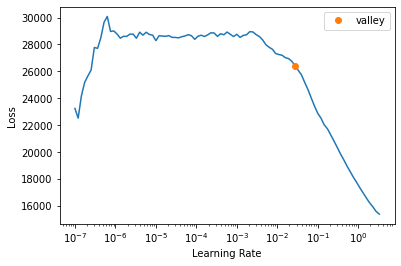

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0  260.20     259.11
1  248.04     247.17
2   23.15      23.16
3  339.01     335.52
4   22.74      22.94
XGBoost RMSE:  1.4167167


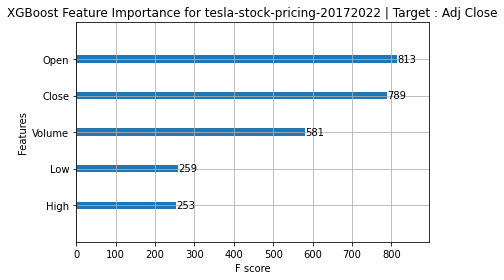

Target Variable: Close
CATS=====================
[]
CONTS=====================
['Open', 'High', 'Low', 'Adj Close', 'Volume']
5
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Open', 'High', 'Low', 'Adj Close', 'Volume']
Categorical variables that made the cut : []
Tabular Object size: 1259


 14%|█▍        | 6/42 [00:00<00:01, 27.42it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9985499638317777, 'Adjusted R-Squared': 0.9985203712569161, 'RMSE': 4.659014328869428, 'Time taken': 0.1485910415649414}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9999509453800383, 'Adjusted R-Squared': 0.9999499442653451, 'RMSE': 0.8569284988326155, 'Time taken': 0.05721449851989746}
{'Model': 'BayesianRidge', 'R-Squared': 0.9999999999999977, 'Adjusted R-Squared': 0.9999999999999977, 'RMSE': 5.8843219671489434e-06, 'Time taken': 0.010869979858398438}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9999352410252075, 'Adjusted R-Squared': 0.999933919413477, 'RMSE': 0.9845881647501726, 'Time taken': 0.014816522598266602}
{'Model': 'DummyRegressor', 'R-Squared': -0.010081612261544137, 'Adjusted R-Squared': -0.0306955227158614, 'RMSE': 122.965385, 'Time taken': 0.009370088577270508}
{'Model': 'ElasticNet', 'R-Squared': 0.9850435497559745, 'Adjusted R-Squared': 0.984738316077525, 'RMSE': 14.963007, 'Time taken': 0.009894609451293945}
{'Mode

 24%|██▍       | 10/42 [00:00<00:01, 16.04it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9999773793200286, 'Adjusted R-Squared': 0.9999769176734986, 'RMSE': 0.5819121919522117, 'Time taken': 0.26218104362487793}
{'Model': 'GammaRegressor', 'R-Squared': 0.8741753561500751, 'Adjusted R-Squared': 0.8716075062755868, 'RMSE': 43.399775555587915, 'Time taken': 0.013505935668945312}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9998083628059833, 'Adjusted R-Squared': 0.9998044518428401, 'RMSE': 1.6937313660323223, 'Time taken': 0.15592694282531738}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': 0.9578588690204247, 'Adjusted R-Squared': 0.9569988459392089, 'RMSE': 25.116419153389113, 'Time taken': 0.03263211250305176}


 31%|███       | 13/42 [00:01<00:02, 11.03it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999371776467681, 'Adjusted R-Squared': 0.9999358955579267, 'RMSE': 0.9697543331684404, 'Time taken': 0.24045300483703613}


 36%|███▌      | 15/42 [00:01<00:03,  7.64it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9997325774121684, 'Adjusted R-Squared': 0.9997271198083351, 'RMSE': 2.0007999700003194, 'Time taken': 0.4344148635864258}
{'Model': 'HuberRegressor', 'R-Squared': 0.9999999999999974, 'Adjusted R-Squared': 0.9999999999999974, 'RMSE': 6.200280629505521e-06, 'Time taken': 0.06726908683776855}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9993486847994849, 'Adjusted R-Squared': 0.9993353926525356, 'RMSE': 3.122484, 'Time taken': 0.014329910278320312}
{'Model': 'KernelRidge', 'R-Squared': 0.052222615290455354, 'Adjusted R-Squared': 0.03288021968413812, 'RMSE': 119.112625, 'Time taken': 0.1146550178527832}


 52%|█████▏    | 22/42 [00:01<00:01, 13.10it/s]

{'Model': 'Lars', 'R-Squared': 0.9999999994550365, 'Adjusted R-Squared': 0.9999999994439148, 'RMSE': 0.002856198176497858, 'Time taken': 0.048737525939941406}
{'Model': 'LarsCV', 'R-Squared': 0.9999999999724278, 'Adjusted R-Squared': 0.9999999999718652, 'RMSE': 0.0006424505194500519, 'Time taken': 0.062145233154296875}
{'Model': 'Lasso', 'R-Squared': 0.9997571420058537, 'Adjusted R-Squared': 0.9997521857202589, 'RMSE': 1.9066932, 'Time taken': 0.01369476318359375}
{'Model': 'LassoCV', 'R-Squared': 0.9998691342604019, 'Adjusted R-Squared': 0.9998664635310224, 'RMSE': 1.3996441, 'Time taken': 0.07877826690673828}
{'Model': 'LassoLars', 'R-Squared': 0.9261519601642942, 'Adjusted R-Squared': 0.9246448573105044, 'RMSE': 33.24865754004082, 'Time taken': 0.011739730834960938}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999999724278, 'Adjusted R-Squared': 0.9999999999718652, 'RMSE': 0.0006424505194500519, 'Time taken': 0.02350902557373047}
{'Model': 'LassoLarsIC', 'R-Squared': 0.99999999999999

 69%|██████▉   | 29/42 [00:03<00:01,  7.07it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9719083812288579, 'Adjusted R-Squared': 0.9713350828865898, 'RMSE': 20.50656937717597, 'Time taken': 1.2306396961212158}
{'Model': 'NuSVR', 'R-Squared': 0.9443757907492711, 'Adjusted R-Squared': 0.9432406028053787, 'RMSE': 28.856028198846037, 'Time taken': 0.10738897323608398}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9999999999999241, 'Adjusted R-Squared': 0.9999999999999225, 'RMSE': 3.3725632044949364e-05, 'Time taken': 0.015503644943237305}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9999999999999241, 'Adjusted R-Squared': 0.9999999999999225, 'RMSE': 3.3725632044949364e-05, 'Time taken': 0.015718936920166016}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9999983721886111, 'Adjusted R-Squared': 0.9999983389679705, 'RMSE': 0.15610135396580735, 'Time taken': 0.01674962043762207}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8743472534396161, 'Adjusted R-Squared': 0.8717829116730776, 'RMSE': 43.370119785061696, 'Ti

 88%|████████▊ | 37/42 [00:03<00:00,  9.74it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9999584714834809, 'Adjusted R-Squared': 0.9999576239627357, 'RMSE': 0.7884566807869382, 'Time taken': 0.4644479751586914}
{'Model': 'Ridge', 'R-Squared': 0.9998775168407665, 'Adjusted R-Squared': 0.9998750171844556, 'RMSE': 1.3540753, 'Time taken': 0.010782480239868164}
{'Model': 'RidgeCV', 'R-Squared': 0.9999916099166198, 'Adjusted R-Squared': 0.9999914386904284, 'RMSE': 0.35439514776213676, 'Time taken': 0.010239601135253906}
{'Model': 'SGDRegressor', 'R-Squared': 0.9997983334127551, 'Adjusted R-Squared': 0.9997942177681175, 'RMSE': 1.7374871569911299, 'Time taken': 0.0950164794921875}
{'Model': 'SVR', 'R-Squared': 0.9467833602925128, 'Adjusted R-Squared': 0.9456973064209314, 'RMSE': 28.22463619359044, 'Time taken': 0.07747602462768555}


 95%|█████████▌| 40/42 [00:04<00:00, 11.89it/s]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999999545, 'Adjusted R-Squared': 0.9999999999999536, 'RMSE': 2.6094684e-05, 'Time taken': 0.015231132507324219}
{'Model': 'TweedieRegressor', 'R-Squared': 0.9578588690204247, 'Adjusted R-Squared': 0.9569988459392089, 'RMSE': 25.116419153389113, 'Time taken': 0.01267242431640625}
{'Model': 'XGBRegressor', 'R-Squared': 0.9998161480553156, 'Adjusted R-Squared': 0.9998123959748119, 'RMSE': 1.6589707, 'Time taken': 0.0953373908996582}


100%|██████████| 42/42 [00:04<00:00,  9.77it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9997258320802352, 'Adjusted R-Squared': 0.9997202368165665, 'RMSE': 2.0258764085340415, 'Time taken': 0.11669206619262695}
Project: tesla-stock-pricing-20172022
tesla-stock-pricing-20172022
Target: Close
Close
Target Standard Deviation: 117.4190902709961
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
BayesianRidge                                1.00       1.00   0.00   
HuberRegressor                               1.00       1.00   0.00   
LassoLarsIC                                  1.00       1.00   0.00   
RANSACRegressor                              1.00       1.00   0.00   
LinearRegression                             1.00       1.00   0.00   
TransformedTargetRegressor                   1.00       1.00   0.00   
OrthogonalMatchingPursuitCV                  1.00       1.00   0.00   
OrthogonalMatchingPursuit                    1.00       1.00   0

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,23045.103516,3448.120605,58.720703,00:00
1,14508.883789,137432.609375,370.719055,00:00


Better model found at epoch 0 with _rmse value: 58.720703125.
No improvement since epoch 0: early stopping


,Open,High,Low,Adj Close,Volume,Close,Close_pred
0,1.00,0.97,1.02,0.97,-0.96,233.03,158.03
1,-0.82,-0.82,-0.82,-0.82,-0.37,22.53,6.38
2,-0.85,-0.85,-0.85,-0.85,-0.23,19.45,6.17
3,1.22,1.21,1.27,1.24,-1.00,263.98,200.36
4,0.85,0.94,0.88,0.98,-0.13,233.94,143.04
5,1.51,1.50,1.50,1.44,-0.84,288.09,241.19
6,1.83,1.91,1.90,1.98,-0.59,351.58,296.17
7,1.55,1.55,1.57,1.57,-0.77,303.08,251.39
8,0.66,0.65,0.68,0.67,-0.06,197.79,96.73


<Figure size 432x288 with 0 Axes>

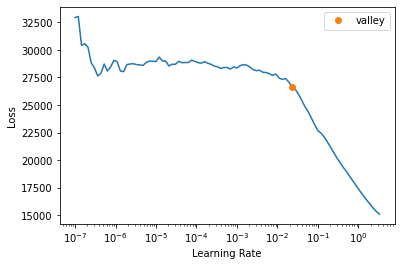

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   20.13      20.09
1  234.52     234.26
2   20.76      20.87
3  289.91     291.01
4   19.02      18.93
XGBoost RMSE:  1.6589707


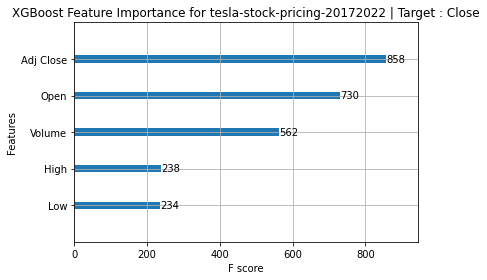

Target Variable: Low
CATS=====================
[]
CONTS=====================
['Open', 'High', 'Close', 'Adj Close', 'Volume']
5
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Open', 'High', 'Close', 'Adj Close', 'Volume']
Categorical variables that made the cut : []
Tabular Object size: 1259


 14%|█▍        | 6/42 [00:00<00:01, 27.08it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9979174999872135, 'Adjusted R-Squared': 0.9978749999869525, 'RMSE': 4.927563436996413, 'Time taken': 0.14649176597595215}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9996011967129756, 'Adjusted R-Squared': 0.9995930578703833, 'RMSE': 2.1563491516526923, 'Time taken': 0.05838131904602051}
{'Model': 'BayesianRidge', 'R-Squared': 0.9996160988357596, 'Adjusted R-Squared': 0.9996082641181221, 'RMSE': 2.1156773288548028, 'Time taken': 0.010977983474731445}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9992262496510245, 'Adjusted R-Squared': 0.999210458827576, 'RMSE': 3.003586520503436, 'Time taken': 0.015481233596801758}
{'Model': 'DummyRegressor', 'R-Squared': -0.03126821383085798, 'Adjusted R-Squared': -0.05231450390903869, 'RMSE': 109.65427, 'Time taken': 0.010497808456420898}
{'Model': 'ElasticNet', 'R-Squared': 0.9857210476847602, 'Adjusted R-Squared': 0.9854296404946533, 'RMSE': 12.902916, 'Time taken': 0.011056661605834961}
{'Model': 

 24%|██▍       | 10/42 [00:00<00:02, 15.91it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.999686278458548, 'Adjusted R-Squared': 0.9996798759781101, 'RMSE': 1.9125459925912447, 'Time taken': 0.2634317874908447}
{'Model': 'GammaRegressor', 'R-Squared': 0.880072613231876, 'Adjusted R-Squared': 0.8776251155427306, 'RMSE': 37.3937399022398, 'Time taken': 0.012887001037597656}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.0771933480688776, 'Adjusted R-Squared': -1.119585049049875, 'RMSE': 155.62457530337994, 'Time taken': 0.1603536605834961}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': 0.958687716742159, 'Adjusted R-Squared': 0.9578446089205704, 'RMSE': 21.947209882601022, 'Time taken': 0.039284467697143555}


 31%|███       | 13/42 [00:01<00:02, 11.03it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9995878988583926, 'Adjusted R-Squared': 0.9995794886310129, 'RMSE': 2.1920054342795954, 'Time taken': 0.2238914966583252}


 40%|████      | 17/42 [00:01<00:02,  8.84it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9993443132984, 'Adjusted R-Squared': 0.9993309319371428, 'RMSE': 2.7649539683570135, 'Time taken': 0.4457895755767822}
{'Model': 'HuberRegressor', 'R-Squared': 0.999626316676974, 'Adjusted R-Squared': 0.9996186904867082, 'RMSE': 2.0873322148115703, 'Time taken': 0.03572988510131836}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9984850685927569, 'Adjusted R-Squared': 0.9984541516252621, 'RMSE': 4.2027755, 'Time taken': 0.013902664184570312}
{'Model': 'KernelRidge', 'R-Squared': -0.28110686060849877, 'Adjusted R-Squared': -0.3072518985801007, 'RMSE': 122.21722, 'Time taken': 0.12518858909606934}


 52%|█████▏    | 22/42 [00:01<00:01, 13.23it/s]

{'Model': 'Lars', 'R-Squared': 0.6772536537905193, 'Adjusted R-Squared': 0.6706669936637952, 'RMSE': 61.34375897991643, 'Time taken': 0.0585169792175293}
{'Model': 'LarsCV', 'R-Squared': 0.9995634640580604, 'Adjusted R-Squared': 0.9995545551612861, 'RMSE': 2.2560551979125196, 'Time taken': 0.05367255210876465}
{'Model': 'Lasso', 'R-Squared': 0.9995028246009092, 'Adjusted R-Squared': 0.9994926781641931, 'RMSE': 2.4076567, 'Time taken': 0.013936996459960938}
{'Model': 'LassoCV', 'R-Squared': 0.9995335293696667, 'Adjusted R-Squared': 0.9995240095608844, 'RMSE': 2.3321252, 'Time taken': 0.07839655876159668}
{'Model': 'LassoLars', 'R-Squared': 0.9239172513452241, 'Adjusted R-Squared': 0.9223645421890041, 'RMSE': 29.783985700638258, 'Time taken': 0.011451005935668945}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9995634640580604, 'Adjusted R-Squared': 0.9995545551612861, 'RMSE': 2.2560551979125196, 'Time taken': 0.02461719512939453}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9994634129828126, 'Adjus

 69%|██████▉   | 29/42 [00:03<00:01,  7.01it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9548388784396602, 'Adjusted R-Squared': 0.9539172228976125, 'RMSE': 22.946797184857395, 'Time taken': 1.2395901679992676}
{'Model': 'NuSVR', 'R-Squared': 0.9627513147865315, 'Adjusted R-Squared': 0.961991137537277, 'RMSE': 20.839878930592413, 'Time taken': 0.11338949203491211}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9992107079982331, 'Adjusted R-Squared': 0.999194599998197, 'RMSE': 3.0336017671799063, 'Time taken': 0.012714147567749023}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9996161093900034, 'Adjusted R-Squared': 0.9996082748877586, 'RMSE': 2.115648246463374, 'Time taken': 0.018677473068237305}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9993820783813898, 'Adjusted R-Squared': 0.999369467736112, 'RMSE': 2.684147715799431, 'Time taken': 0.012046575546264648}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9008520189120692, 'Adjusted R-Squared': 0.8988285907266013, 'RMSE': 34.00021437404833, 'Time taken': 0.

 90%|█████████ | 38/42 [00:03<00:00, 10.65it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9996101054758428, 'Adjusted R-Squared': 0.9996021484447376, 'RMSE': 2.132128059172826, 'Time taken': 0.46247434616088867}
{'Model': 'Ridge', 'R-Squared': 0.9995282727781744, 'Adjusted R-Squared': 0.9995186456920147, 'RMSE': 2.3452287, 'Time taken': 0.012146711349487305}
{'Model': 'RidgeCV', 'R-Squared': 0.9996032087937333, 'Adjusted R-Squared': 0.9995951110140135, 'RMSE': 2.150902562828617, 'Time taken': 0.010373115539550781}
{'Model': 'SGDRegressor', 'R-Squared': 0.9994855976731791, 'Adjusted R-Squared': 0.9994750996665093, 'RMSE': 2.449013504106524, 'Time taken': 0.011620759963989258}
{'Model': 'SVR', 'R-Squared': 0.965904034272534, 'Adjusted R-Squared': 0.9652081982372797, 'RMSE': 19.938441829467866, 'Time taken': 0.07411313056945801}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9996161280384133, 'Adjusted R-Squared': 0.9996082939167482, 'RMSE': 2.1155968, 'Time taken': 0.012662887573242188}
{'Model': 'TweedieRegressor', 'R

100%|██████████| 42/42 [00:04<00:00,  9.97it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9995372606672934, 'Adjusted R-Squared': 0.9995278170074423, 'RMSE': 2.3227794, 'Time taken': 0.0978555679321289}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9993836082997795, 'Adjusted R-Squared': 0.999371028877326, 'RMSE': 2.6808228022289855, 'Time taken': 0.11307954788208008}
Project: tesla-stock-pricing-20172022
tesla-stock-pricing-20172022
Target: Low
Low
Target Standard Deviation: 117.11224365234375
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
ExtraTreesRegressor                          1.00       1.00   1.91   
HuberRegressor                               1.00       1.00   2.09   
TransformedTargetRegressor                   1.00       1.00   2.12   
LinearRegression                             1.00       1.00   2.12   
OrthogonalMatchingPursuitCV                  1.00       1.00   2.12   
BayesianRidge                                1.00       

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,24171.894531,3473.389160,58.935467,00:00
1,15493.080078,100250.898438,316.624237,00:00


Better model found at epoch 0 with _rmse value: 58.93546676635742.
No improvement since epoch 0: early stopping


,Open,High,Close,Adj Close,Volume,Low,Low_pred
0,1.06,1.02,1.07,1.07,-0.53,250.00,156.97
1,1.48,1.46,1.46,1.46,-0.86,297.80,235.03
2,0.86,0.82,0.84,0.84,-0.87,224.27,132.09
3,-0.86,-0.86,-0.87,-0.87,0.07,20.79,-2.37
4,0.82,0.85,0.86,0.86,-0.48,223.00,124.66
5,-0.88,-0.88,-0.88,-0.88,-0.78,19.50,21.58
6,1.55,1.52,1.54,1.54,-0.91,306.67,249.54
7,-0.85,-0.86,-0.86,-0.86,-0.67,22.24,16.66
8,2.20,2.16,2.04,2.04,-0.25,354.23,323.74


<Figure size 432x288 with 0 Axes>

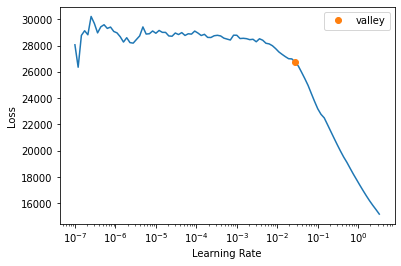

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   16.96      17.14
1  245.47     238.45
2   20.46      20.22
3  297.80     291.73
4   42.17      40.44
XGBoost RMSE:  2.3227794


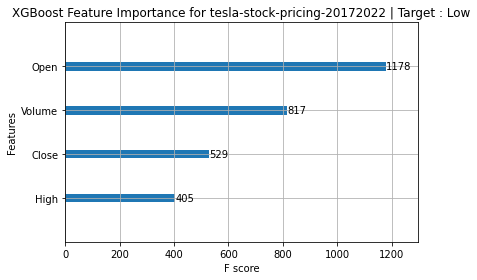

Target Variable: High
CATS=====================
[]
CONTS=====================
['Open', 'Low', 'Close', 'Adj Close', 'Volume']
5
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Open', 'Low', 'Close', 'Adj Close', 'Volume']
Categorical variables that made the cut : []
Tabular Object size: 1259


  2%|▏         | 1/42 [00:00<00:05,  6.91it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9977160644236317, 'Adjusted R-Squared': 0.9976694534935018, 'RMSE': 5.736008179518129, 'Time taken': 0.14449763298034668}


 14%|█▍        | 6/42 [00:00<00:01, 27.52it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9996419788420006, 'Adjusted R-Squared': 0.9996346722877557, 'RMSE': 2.271026404691732, 'Time taken': 0.058777570724487305}
{'Model': 'BayesianRidge', 'R-Squared': 0.9996530132115097, 'Adjusted R-Squared': 0.9996459318484793, 'RMSE': 2.2357554953916994, 'Time taken': 0.011076927185058594}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9992730451090014, 'Adjusted R-Squared': 0.9992582092948994, 'RMSE': 3.2360972817269773, 'Time taken': 0.015083789825439453}
{'Model': 'DummyRegressor', 'R-Squared': -0.00297951693782994, 'Adjusted R-Squared': -0.023448486671254987, 'RMSE': 120.2026, 'Time taken': 0.009177923202514648}
{'Model': 'ElasticNet', 'R-Squared': 0.9857131387763994, 'Adjusted R-Squared': 0.9854215701799994, 'RMSE': 14.346179, 'Time taken': 0.010200023651123047}
{'Model': 'ElasticNetCV', 'R-Squared': 0.9984170424909188, 'Adjusted R-Squared': 0.9983847372356314, 'RMSE': 4.77532, 'Time taken': 0.0646657943725586}
{'Model': 'ExtraTreeRegr

 24%|██▍       | 10/42 [00:00<00:01, 16.03it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9997401483362012, 'Adjusted R-Squared': 0.9997348452410216, 'RMSE': 1.9347755395643176, 'Time taken': 0.26229238510131836}
{'Model': 'GammaRegressor', 'R-Squared': 0.872935037445052, 'Adjusted R-Squared': 0.8703418749439306, 'RMSE': 42.78393675897487, 'Time taken': 0.013367414474487305}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.3199827029501985, 'Adjusted R-Squared': 0.30610479892877396, 'RMSE': 98.97552567664162, 'Time taken': 0.14874887466430664}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': 0.9585803815726147, 'Adjusted R-Squared': 0.9577350832373619, 'RMSE': 24.42704227760403, 'Time taken': 0.03916001319885254}


 31%|███       | 13/42 [00:01<00:02, 11.11it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9996352250703545, 'Adjusted R-Squared': 0.9996277806840352, 'RMSE': 2.2923468393907327, 'Time taken': 0.2351081371307373}


 40%|████      | 17/42 [00:01<00:02,  8.84it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9992400630903074, 'Adjusted R-Squared': 0.9992245541737831, 'RMSE': 3.3086940194938728, 'Time taken': 0.4373941421508789}
{'Model': 'HuberRegressor', 'R-Squared': 0.9996387784251585, 'Adjusted R-Squared': 0.9996314065562841, 'RMSE': 2.281154382013696, 'Time taken': 0.04098224639892578}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9990355520472454, 'Adjusted R-Squared': 0.9990158694359647, 'RMSE': 3.7274106, 'Time taken': 0.014044046401977539}
{'Model': 'KernelRidge', 'R-Squared': -0.09168551013136539, 'Adjusted R-Squared': -0.1139648062564953, 'RMSE': 125.40551, 'Time taken': 0.13042616844177246}


 52%|█████▏    | 22/42 [00:01<00:01, 13.24it/s]

{'Model': 'Lars', 'R-Squared': 0.9996532242662057, 'Adjusted R-Squared': 0.999646147210414, 'RMSE': 2.2350754428838084, 'Time taken': 0.043047189712524414}
{'Model': 'LarsCV', 'R-Squared': 0.9995959550501311, 'Adjusted R-Squared': 0.9995877092348276, 'RMSE': 2.412585307585122, 'Time taken': 0.06573152542114258}
{'Model': 'Lasso', 'R-Squared': 0.9995145323654433, 'Adjusted R-Squared': 0.9995046248626972, 'RMSE': 2.6445267, 'Time taken': 0.013880491256713867}
{'Model': 'LassoCV', 'R-Squared': 0.9995990783029689, 'Adjusted R-Squared': 0.9995908962275193, 'RMSE': 2.4032426, 'Time taken': 0.08038997650146484}
{'Model': 'LassoLars', 'R-Squared': 0.9313528424017831, 'Adjusted R-Squared': 0.9299518800018195, 'RMSE': 31.44699249378758, 'Time taken': 0.01122593879699707}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9995966575004183, 'Adjusted R-Squared': 0.999588426020835, 'RMSE': 2.4104872013337695, 'Time taken': 0.02628040313720703}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9995641098120779, 'Adjuste

 69%|██████▉   | 29/42 [00:03<00:01,  6.68it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9680872617874582, 'Adjusted R-Squared': 0.9674359814157737, 'RMSE': 21.44123871432515, 'Time taken': 1.348757266998291}
{'Model': 'NuSVR', 'R-Squared': 0.9539092578003856, 'Adjusted R-Squared': 0.9529686304085567, 'RMSE': 25.76764259383743, 'Time taken': 0.10761857032775879}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9992185024191864, 'Adjusted R-Squared': 0.9992025534889657, 'RMSE': 3.3553023127801374, 'Time taken': 0.013640165328979492}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9996532275969267, 'Adjusted R-Squared': 0.9996461506091088, 'RMSE': 2.235064709101416, 'Time taken': 0.01747417449951172}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9995061071835091, 'Adjusted R-Squared': 0.9994960277382746, 'RMSE': 2.667375709792505, 'Time taken': 0.012168407440185547}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8677906955819299, 'Adjusted R-Squared': 0.8650925465121734, 'RMSE': 43.64141740816162, 'Time taken': 0.0

 90%|█████████ | 38/42 [00:04<00:00, 10.42it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9996606722254067, 'Adjusted R-Squared': 0.9996537471687823, 'RMSE': 2.2109429767281013, 'Time taken': 0.4433872699737549}
{'Model': 'Ridge', 'R-Squared': 0.9995484343086178, 'Adjusted R-Squared': 0.9995392186822631, 'RMSE': 2.5505176, 'Time taken': 0.011861085891723633}
{'Model': 'RidgeCV', 'R-Squared': 0.9996374675856851, 'Adjusted R-Squared': 0.9996300689649847, 'RMSE': 2.2852896822202453, 'Time taken': 0.01067805290222168}
{'Model': 'SGDRegressor', 'R-Squared': 0.9994300221784639, 'Adjusted R-Squared': 0.9994183899780243, 'RMSE': 2.865476266836045, 'Time taken': 0.014086723327636719}
{'Model': 'SVR', 'R-Squared': 0.9573179005878222, 'Adjusted R-Squared': 0.9564468373345124, 'RMSE': 24.796519343150017, 'Time taken': 0.0794072151184082}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9996532202477023, 'Adjusted R-Squared': 0.9996461431099003, 'RMSE': 2.2350883, 'Time taken': 0.012887954711914062}
{'Model': 'TweedieRegressor', 'R

100%|██████████| 42/42 [00:04<00:00,  9.79it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9994005327634895, 'Adjusted R-Squared': 0.9993882987382546, 'RMSE': 2.9386683, 'Time taken': 0.09804773330688477}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9991715536053476, 'Adjusted R-Squared': 0.999154646536069, 'RMSE': 3.4546180939196955, 'Time taken': 0.11396312713623047}
Project: tesla-stock-pricing-20172022
tesla-stock-pricing-20172022
Target: High
High
Target Standard Deviation: 121.65182495117188
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
ExtraTreesRegressor                          1.00       1.00   1.93   
RandomForestRegressor                        1.00       1.00   2.21   
OrthogonalMatchingPursuitCV                  1.00       1.00   2.24   
Lars                                         1.00       1.00   2.24   
RANSACRegressor                              1.00       1.00   2.24   
LinearRegression                             1.00    

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,24323.998047,2753.208252,52.471024,00:00
1,15802.238281,368837.812500,607.320190,00:00


Better model found at epoch 0 with _rmse value: 52.47102355957031.
No improvement since epoch 0: early stopping


,Open,Low,Close,Adj Close,Volume,High,High_pred
0,1.15,1.17,1.14,1.14,-0.89,260.26,211.30
1,1.78,1.71,1.68,1.68,-0.59,335.00,327.37
2,1.02,1.05,1.03,1.03,-0.94,244.67,185.32
3,1.43,1.42,1.37,1.37,-0.84,292.69,261.77
4,-0.68,-0.68,-0.66,-0.66,2.47,46.03,3.73
5,-0.87,-0.87,-0.87,-0.87,-0.65,19.44,-0.98
6,-0.90,-0.90,-0.90,-0.90,-0.30,15.70,-4.47
7,-0.83,-0.83,-0.83,-0.83,-0.78,23.99,0.42
8,-0.82,-0.81,-0.81,-0.81,0.84,26.35,8.00


<Figure size 432x288 with 0 Axes>

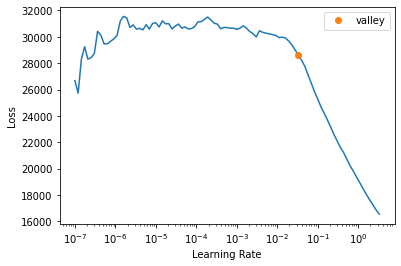

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   18.93      19.21
1   23.83      24.19
2   28.60      28.04
3  231.09     230.71
4  368.00     368.75
XGBoost RMSE:  2.9386683


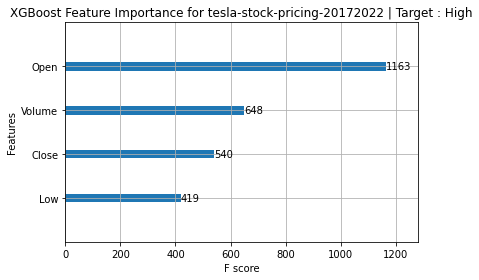

<Figure size 432x288 with 0 Axes>

In [16]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

  feature  importance
0     Low         259
1    Open         813
2    High         253
3   Close         789
4  Volume         581


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

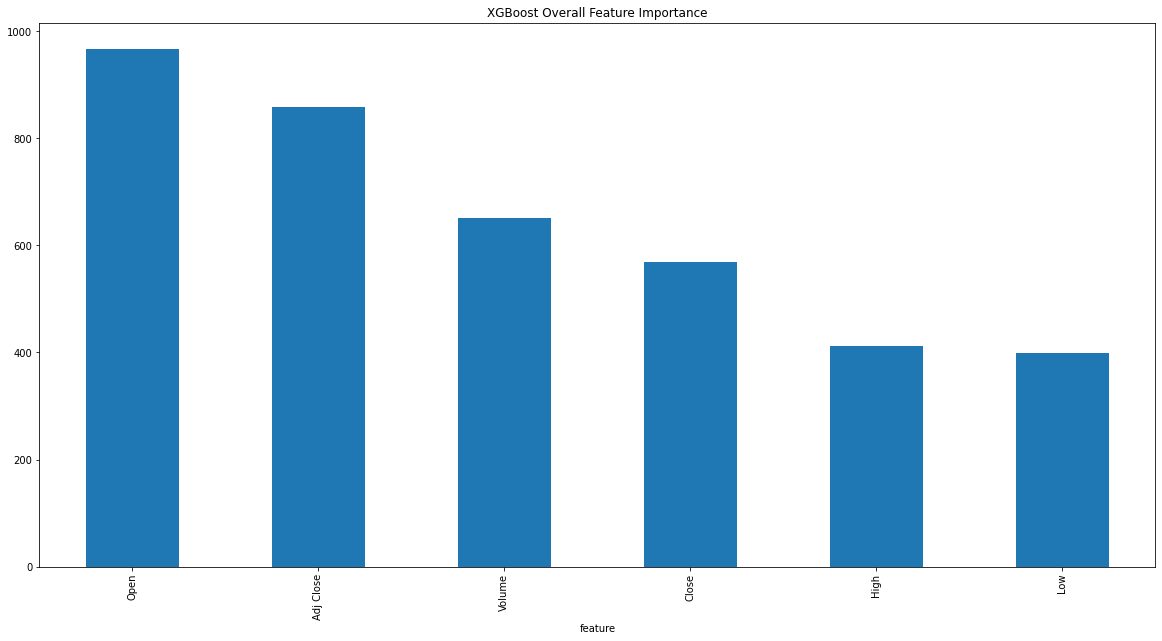

In [17]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [18]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# **To Be Continued...**